##### **Lokendra Kumar Meena**


##### **Objective:** The goal is to build a text classification model using the Hugging Face library to classify a dataset of text into one of multiple categories. The candidate will use a pre-trained model such as BERT or GPT-2 as a starting point and fine-tune it on the classification task.

##### **Task summary**
- Obtain a good standard text classification dataset that supports multi-class classification.
- Use a pre-trained Tensorflow Hugging Face Transformer to fine-tune the model with the obtained data.
- Use the Evaluation Metrics (We will be using a Confusion Matrix, and F1 Score to evaluate the model) and determine how good the model really is at prediction.

##### **Dataset Summary:**
- The dataset contains three distinct classes: World, Sports, Business, Science/Tech.
- Both the training and test CSVs contain three columns: Class Index, Title, Description.
- The Class Index represents the category of the article (1 for World, 2 for Sports, 3 for Business, and 4 for Science/Tech.)
- The title column contains the title of the articles.
- The description column contains the actual content of the article.

### **1. Preliminary Steps**

In [ ]:
#!pip install apex


##### **Importing all required libraries**

In [ ]:
# General Libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import re
import torch
import os

# Importing the required Transformer models
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, logging

# The training-validation split
from sklearn.model_selection import train_test_split

# The transformers library doesn't work particularly well with pandas dataframes
from datasets import Dataset

# Metrics and Visualizers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support as score
import matplotlib.pyplot as plt

In [ ]:
!pip install datasets

In [ ]:
# Disable from connecting to Weights and Biases
os.environ["WANDB_DISABLED"] = "true"

##### **Loading the training and testing datasets**

In [ ]:
df_train = pd.read_csv('/train.csv', header=0, names=['labels', 'title', 'description']).sample(frac = 0.5)
df_test = pd.read_csv('/test.csv', header=0, names= ['labels', 'title', 'description'])

##### **Viewing the head of the training dataframe**

In [ ]:
df_train.head()

,labels,title,description
35187,1,"2 Assessments of Iraq, 2 Election Strategies",The presidential candidates' opposed images of...
8847,4,Experts to Breed Sheep to Study Disease (AP),AP - New Zealand researchers said Tuesday they...
106522,3,Update 1: Blockbuster May Raise Offer for Rival,"Blockbuster Inc., locked in a bidding war for ..."
102712,3,Wal-Mart Sees Nov. US Sales Up 0.7 Pct,"Wal-Mart Stores Inc. (WMT.N: Quote, Profile, R..."
70586,1,Omar Abdullah survives assassination bid,SRINAGAR: The head of held Kashmir #39;s main ...


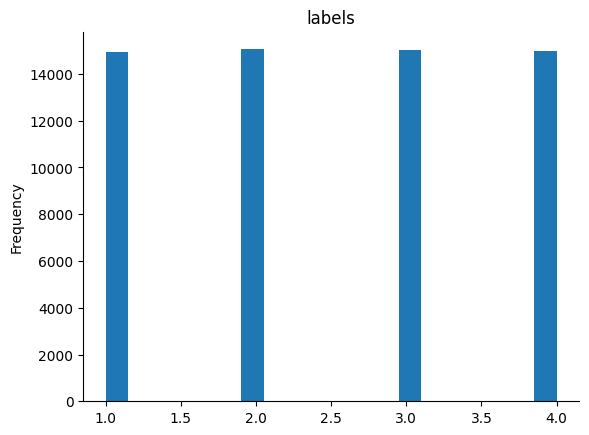

In [ ]:
# @title labels

from matplotlib import pyplot as plt
df_train['labels'].plot(kind='hist', bins=20, title='labels')
plt.gca().spines[['top', 'right',]].set_visible(False)

##### **Viewing the head of the testing dataframe**

In [ ]:
df_test.head()

,labels,title,description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


##### **Making changes to the original dataframes**
- Although we're being provided with two columns worth of text data: Title, and Description we obtain most of the information from the title itself.
- So, it's a better choice to merge the title and description columns with the title column being first.

In [ ]:
df_train['text'] = df_train['title'] + " " + df_train['description']
df_test['text'] = df_test['title'] + " " + df_test['description']

##### **We no longer have much use for the separate title and description columns so we drop them**

In [ ]:
df_train = df_train.drop(['title', 'description'], axis=1)
df_test = df_test.drop(['title', 'description'], axis=1)

#### **Viewing the head once more to confirm the changes made**

In [ ]:
df_train.head()

,labels,text
35187,1,"2 Assessments of Iraq, 2 Election Strategies T..."
8847,4,Experts to Breed Sheep to Study Disease (AP) A...
106522,3,Update 1: Blockbuster May Raise Offer for Riva...
102712,3,Wal-Mart Sees Nov. US Sales Up 0.7 Pct Wal-Mar...
70586,1,Omar Abdullah survives assassination bid SRINA...


#### **Storing the class labels into a variable**

In [ ]:
CLASS_LABELS = {0: "World", 1: "Sports", 2: "Business", 3: "Science/Tech"}

##### **Changing Class Labels**
- Our dataset has class labels in the range 1-4
- But, the loss calculation that we will be doing will be through Cross Entropy
- If there are 'c' classes, cross entropy expects labels from 0 to c-1
- In our case, it's 1 to c
- So, we need to decrease all labels by one.

In [ ]:
df_train['labels'] = df_train['labels'] - 1
df_test['labels'] = df_test['labels'] - 1

### **2. Data Pre-processing**

##### **For our purposes neither punctuation nor digits provide much use to the classification thus, they can be safely removed without any repercussions**

In [ ]:
# Defining a Regular Expression to extract only the words and spaces
df_train['text'] = df_train['text'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))
df_test['text'] = df_test['text'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))

##### **Normalizing the words in the dataframe, so that all are in lowercase**

In [ ]:
# Defining a Regular Expression to convert all words to lowercase
df_train['text'] = df_train['text'].apply(lambda x: x.lower())
df_test['text'] = df_test['text'].apply(lambda x: x.lower())

##### **Analyzing the dataset's shape**

In [ ]:
print("The training dataframe has '{}' rows and '{}' columns".format(df_train.shape[0],df_train.shape[1]))
print("The testing dataframe has '{}' rows and '{}' columns".format(df_test.shape[0],df_test.shape[1]))

The training dataframe has '60000' rows and '2' columns
The testing dataframe has '7600' rows and '2' columns


##### **Analyzing the class distribution in the training and testing dataframes**

<Axes: ylabel='Frequency'>

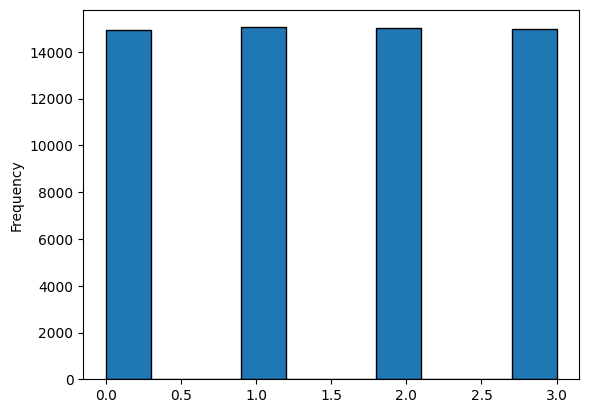

In [ ]:
df_train['labels'].plot(kind='hist', edgecolor='black')

<Axes: ylabel='Frequency'>

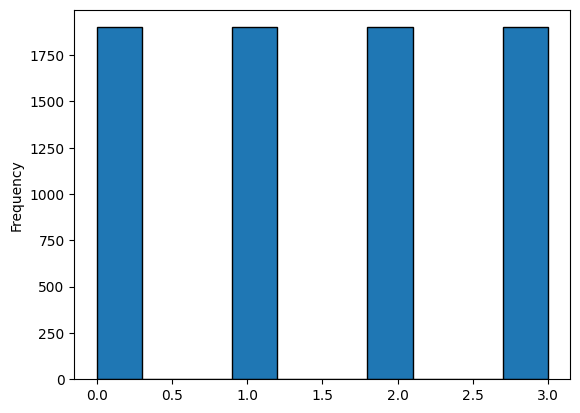

In [ ]:
df_test['labels'].plot(kind='hist', edgecolor='black')

##### It can be observed that the training data is well distributed with 30,000 samples in each class and that the training dataset has a little over 1,750 samples for each class

##### **Checking for null values in the dataframes**

In [ ]:
print('Null values in the training dataframe for the class column is "{}" and the text column is "{}"'.format(df_train.isnull().any()['labels'],df_train.isnull().any()['text']))
print('Null values in the testing dataframe for the class column is "{}" and the text column is "{}"'.format(df_test.isnull().any()['labels'],df_test.isnull().any()['text']))

Null values in the training dataframe for the class column is "False" and the text column is "False"
Null values in the testing dataframe for the class column is "False" and the text column is "False"


##### **Checking for empty strings in the text column**

In [ ]:
print("The number of empty strings in the training dataset is '{}'".format(len(df_train[df_train['text'] == ''].index)))
print("The number of empty strings in the testing dataset is '{}'".format(len(df_test[df_test['text'] == ''].index)))

The number of empty strings in the training dataset is '0'
The number of empty strings in the testing dataset is '0'


##### **Checking for strings with just whitespaces (For ex: "   ", " \n ", etc.)**

In [ ]:
train_length_1 = len(np.where(df_train.applymap(lambda x: str(x).isspace() == True))[0])
train_length_2 = len(np.where(df_train.applymap(lambda x: str(x).isspace() == True))[1])
print("The number of strings with just whitespaces in the training dataframe are '{}' in the class column and '{}' in the text column".format(train_length_1, train_length_2))

test_length_1 = len(np.where(df_test.applymap(lambda x: str(x).isspace() == True))[0])
test_length_2 = len(np.where(df_test.applymap(lambda x: str(x).isspace() == True))[1])
print("The number of strings with just whitespaces in the testing dataframe are '{}' in the class column and '{}' in the text column".format(test_length_1, test_length_2))

The number of strings with just whitespaces in the training dataframe are '0' in the class column and '0' in the text column
The number of strings with just whitespaces in the testing dataframe are '0' in the class column and '0' in the text column


##### Thus, from all the above observations we can conclude that the data has no abnormalities and can be proceeded with.
##### If there were null/empty values, we would've simply deleted the columns.
##### If the class distribution was highly un-uniform, we would've undersampled with the majority class and/or oversampled with the minority class

##### **Reviewing the dataframes after general text pre-processing**

In [ ]:
df_train.head()

,labels,text
35187,0,assessments of iraq election strategies t...
8847,3,experts to breed sheep to study disease ap a...
106522,2,update blockbuster may raise offer for riva...
102712,2,wal mart sees nov us sales up pct wal mar...
70586,0,omar abdullah survives assassination bid srina...


In [ ]:
df_test.head()

,labels,text
0,2,fears for t n pension after talks unions repre...
1,3,the race is on second private team sets launc...
2,3,ky company wins grant to study peptides ap ...
3,3,prediction unit helps forecast wildfires ap ...
4,3,calif aims to limit farm related smog ap ap...


##### **Storing the name of the pre-trained model that we will be using**

In [ ]:
model = "distilbert-base-uncased"

##### **Declaring an AutoTokenizer which will automatically use the model specific Tokenization technique**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


##### **Pre-defining functions that will help tokenize the data & convert the dataframe to a Dataset**

In [ ]:
# This is a helper function to tokenize the input plain text for input and attention data
def tokenize(dataset):
    return tokenizer(dataset['text'], truncation=True)

# This function will convert the dataframe to a dataset and then, perform tokenization
# on the dataset using the above helper function
def df_to_ds(dataframe):
    dataset = Dataset.from_pandas(dataframe, preserve_index=False)
    tokenized_ds = dataset.map(tokenize, batched=True)
    tokenized_ds = tokenized_ds.remove_columns('text')

    return tokenized_ds

##### **Performing the training-validation split on the dataframes**

In [ ]:
df_train_in, df_val_in = train_test_split(df_train[['labels', 'text']], test_size=0.2, random_state=42)

##### **Calling the pre-defined functions on the training and testing dataframes**

In [ ]:
tokenized_train = df_to_ds(df_train_in)
tokenized_val = df_to_ds(df_val_in)
tokenized_test = df_to_ds(df_test)

Map:   0%|          | 0/48000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

##### **Final view of the obtained datasets**

In [ ]:
tokenized_train

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 48000
})

In [ ]:
tokenized_val

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 12000
})

In [ ]:
tokenized_test

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 7600
})

### **3. Fine-tune/Training the Transformer Model**

##### **Setting up the Data Collator object**
- The data collator is what will be responsible for the batches that we will be using to train the model (batch training)
- It will be of the same type of the data that's being given to it (In this case, Input IDs, Attention Mask, and such...)
- The Data Collator we are using will also be adding padding to the training batches

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

##### **Loading in the HuggingFace Transformer Model**

In [ ]:
transformer = AutoModelForSequenceClassification.from_pretrained(model, num_labels=4)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#!pip install accelerate

In [ ]:
import accelerate
print(accelerate.__version__)

0.27.2


##### **Fine-tuning the transformer model with our data**

In [ ]:
# Slightly modified training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    save_strategy = 'epoch',
    optim="adamw_torch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    fp16=True,
    num_train_epochs=5,
    weight_decay=0.01,
)


trainer = Trainer (
    model=transformer,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

%time trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
500,0.415100
1000,0.296700
1500,0.268000
2000,0.280200
2500,0.250700
3000,0.239400
3500,0.185700
4000,0.196900
4500,0.177400
5000,0.174300


CPU times: user 15min 6s, sys: 10.9 s, total: 15min 17s
Wall time: 15min 47s


TrainOutput(global_step=15000, training_loss=0.14782714614868164, metrics={'train_runtime': 947.5646, 'train_samples_per_second': 253.281, 'train_steps_per_second': 15.83, 'total_flos': 4553518114153344.0, 'train_loss': 0.14782714614868164, 'epoch': 5.0})

##### **Performing predictions on the testing dataset**

In [ ]:
tokenized_tester = tokenized_test.remove_columns('labels')

predictions = trainer.predict(tokenized_test)

### **4. Reviewing the Accuracy of the Model**

##### **Confusion Matrix**

In [ ]:
preds_flat = [np.argmax(x) for x in predictions[0]]

print(len(preds_flat))

cm = confusion_matrix(df_test['labels'], preds_flat)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()

plt.show()

##### **F1 Score**

In [ ]:
precision, recall, fscore, support = score(df_test['labels'], preds_flat)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.93602517 0.97596656 0.8988883  0.90740741]
recall: [0.93947368 0.98315789 0.89368421 0.90263158]
fscore: [0.93774626 0.97954903 0.8962787  0.90501319]
support: [1900 1900 1900 1900]


##### **Charts**

In [ ]:
DistillBert = {'precision': [0.95132275, 0.98113208, 0.91135881, 0.91188738],
                'recall':[0.94631579, 0.98526316, 0.90368421, 0.92052632],
                'fscore':[0.94881266, 0.98319328, 0.90750529, 0.91618649]}

def show_chart(metric):
    models = [DistillBert]
    model_names = ['DistillBert']
    model_labels = ['Sci/Tech', 'World', 'Sports', 'Business']

    for model in models:
        plt.plot(model_labels, model[metric])

    plt.legend(model_names)
    plt.title(metric.title())

    plt.show()

show_chart('precision')
show_chart('recall')
show_chart('fscore')

### **4. Conclusion**
- There are a vast number of models that can be substitued with DistilBert but, I chose it because of how fast it trains.
- DistilBERT also 'on paper' retains 97% of the original BERT performance but, with a lot of testing I was able to determine that with this dataset DistilBERT actually performs much better than BERT or RoBERTa

- We can also perform hyperparameter tuning using Grid Search techniques like Random Grid Search for even better performance.

### **5. Saving the model for future use**

In [ ]:
trainer.save_model("./DistilBERT-AG-NEWS")

In [ ]:
!zip "./DistilBERT-AG-NEWS/*" "./DistilBERT-AG-NEWS.zip"